##  Age-structured SEIR model for India with social distancing


In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
MM = np.array((0,0,.2,.2,.2,.2,.2,.2,.4,.4,1.3,1.3,3.6,3.6,8,8))  ## mortality per 100

In [3]:
## population and age classes
M=16  ## number of age classes

my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [4]:
# contact matrices
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)
C=CH+CW+CS+CO

### One closure

In [5]:
# epidemic parameters
beta  = 0.0315          # infection rate 
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
gE    = 1/4
alpha = 0.               # fraction of asymptomatic infectives 
fsa   = 1                # the self-isolation parameter   


# initial conditions    
Is_0 = np.zeros((M));  Is_0[4:12]=3;  Is_0[3:4]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
E_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0 + E_0)

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'gE':gE,'fsa':fsa}
model = pyross.models.SEIR(parameters, M, Ni)

# the contact matrix is time-dependent
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<42:
        xx = CH
    else:
        xx = C
    return xx


# start simulation
Tf=98.5;  Nf=2000; filename='this.mat'
model.simulate(S_0, E_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

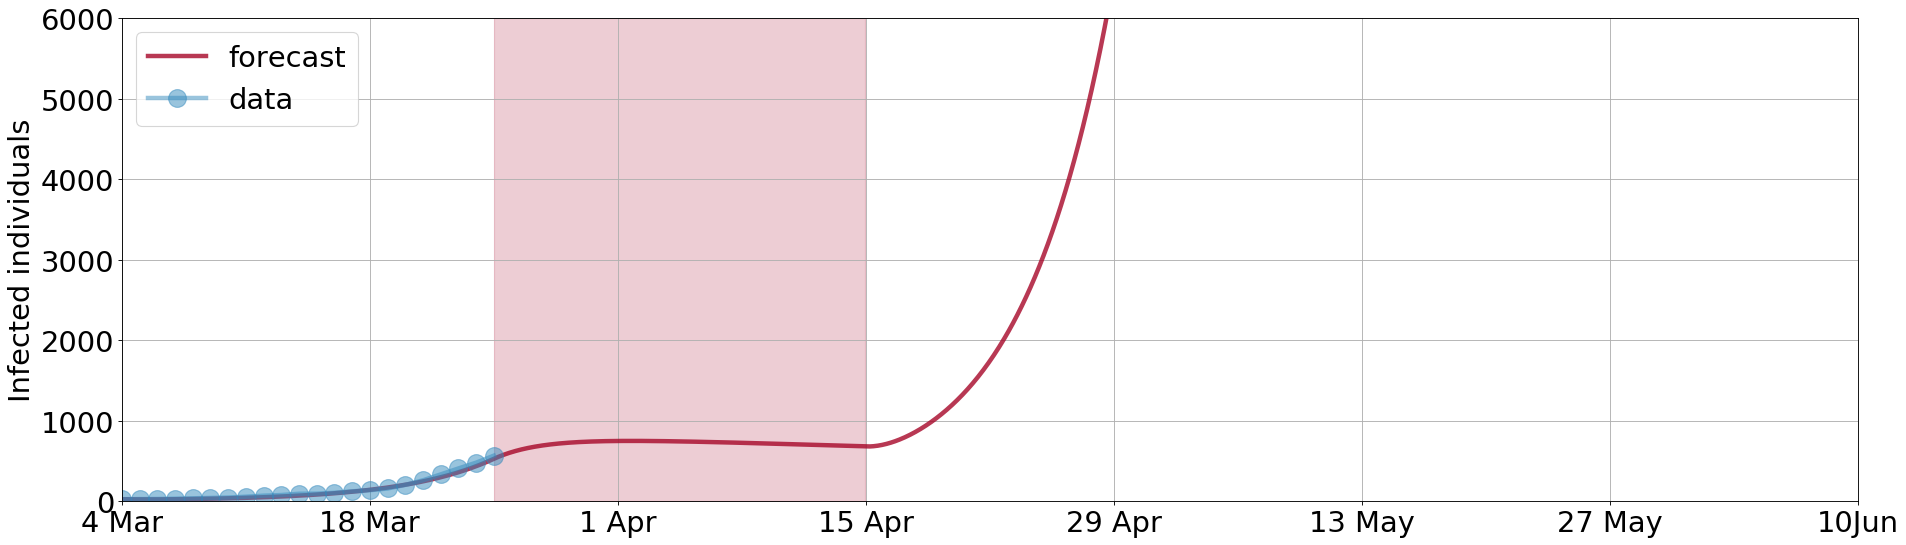

In [6]:
data=loadmat(filename)
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,3*M+i] 
t = data['t'][0]
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));
t1=int(Nf/14)
plt.fill_between(t[3*t1:6*t1], 0, 6000, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3] - my_data[:,1]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.ylim(0, 6000); plt.xlim(0, 98);
plt.savefig('/Users/rsingh/Desktop/4a.png', format='png', dpi=200)

In [7]:
m1 = .01*MM*(data['X'][0,0:M]-data['X'][-1,0:M])
np.sum(m1)

283562.90118735225

### Two closures

In [8]:
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<42:
        xx = CH
    elif 42<=t<47:
        xx = C
    elif 47<=t<75:
        xx = CH
    else:
        xx = C
    return xx

# start simulation
Tf=98;  Nf=2000; filename='this.mat'
model.simulate(S_0, E_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

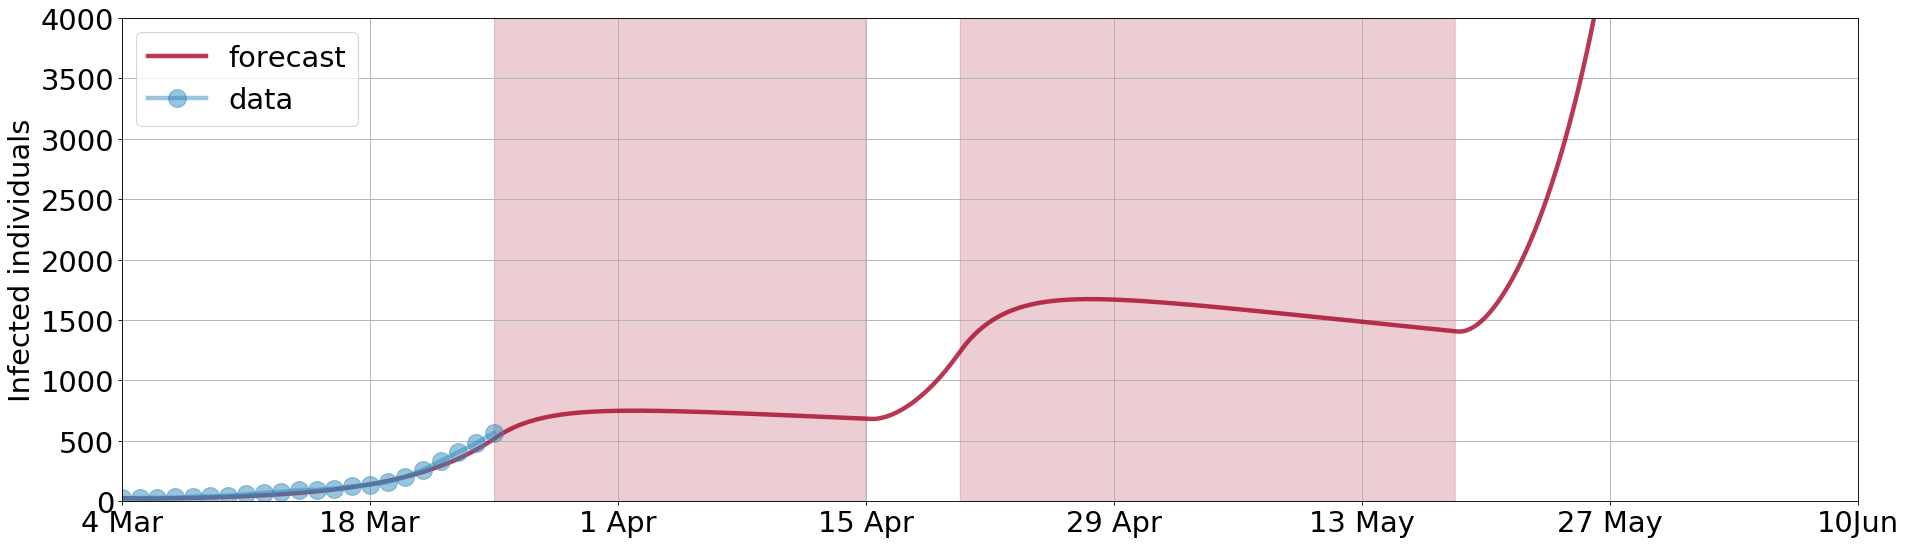

In [9]:
data=loadmat(filename)
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,3*M+i] 
        SC += data['X'][:,0*M+i] 

fig=plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

maxY=4000

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

t1=int(Nf/(14))
plt.fill_between(t[3*t1:6*t1], 0, maxY, color="#A60628", alpha=0.2)
plt.fill_between(t[6*t1+108:10*t1+108], 0, maxY, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3] - my_data[:,1]


plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 98); plt.ylim(0, maxY);
plt.savefig('/Users/rsingh/Desktop/4b.png', format='png', dpi=200)

In [10]:
m1 = .01*MM*(data['X'][0,0:M]-data['X'][-1,0:M])
np.sum(m1)
SC[-1]-SC[0]

-242933.74785804749

In [11]:
## Three closures

In [12]:
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<42:
        xx = CH
    elif 42<=t<47:
        xx = C
    elif 47<=t<75:
        xx = CH
    elif 75<=t<80:
        xx = C
    else:
        xx = CH
    return xx


# start simulation
Tf=98;  Nf=2000; filename='this.mat'
model.simulate(S_0, E_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

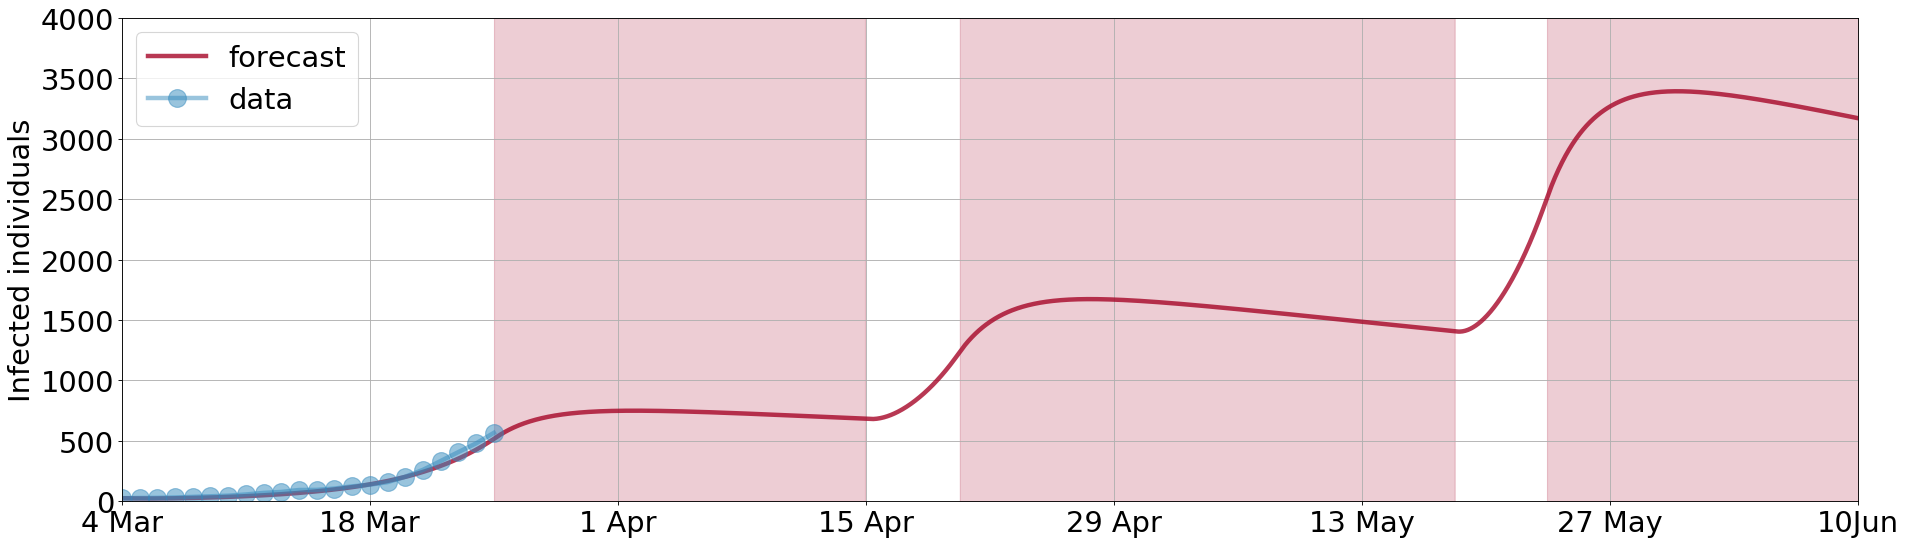

In [13]:
data=loadmat(filename)
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,3*M+i] 
        SC += data['X'][:,0*M+i] 

fig=plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

maxY=4000
plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

t1=int(Nf/(14))
plt.fill_between(t[3*t1:6*t1], 0, maxY, color="#A60628", alpha=0.2)
plt.fill_between(t[6*t1+108:10*t1+108], 0, maxY, color="#A60628", alpha=0.2)
plt.fill_between(t[10*t1+213:14*t1+410], 0, maxY, color="#A60628", alpha=0.2)


my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3] - my_data[:,1]


plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 

plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 98); plt.ylim(0, maxY);
plt.savefig('/Users/rsingh/Desktop/4c.png', format='png', dpi=200)

### One long closure

In [14]:
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<70:
        xx = CH
    else:
        xx = CH
    return xx


# start simulation
Tf=84;  Nf=2000; filename='this.mat'
model.simulate(S_0, E_0, Ia_0, Is_0, contactMatrix, Tf, Nf, filename)

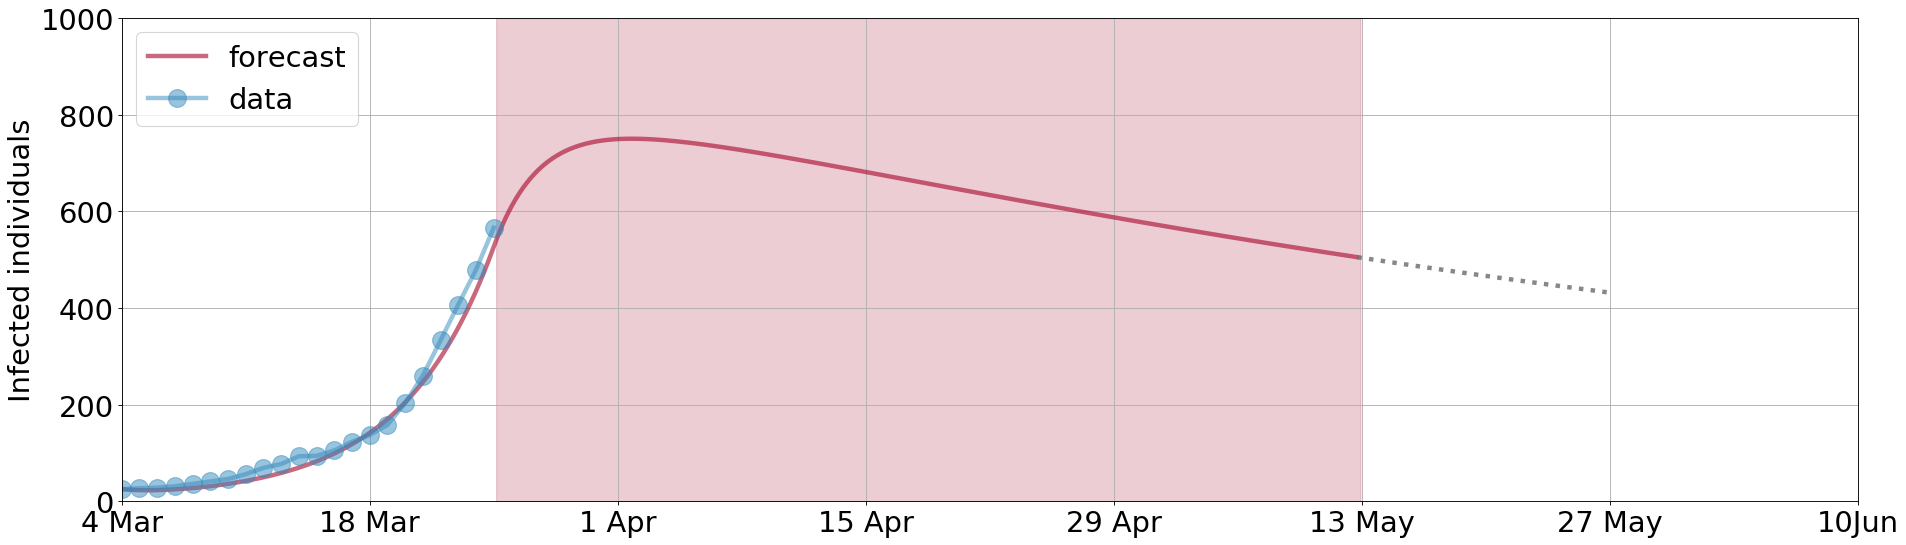

In [17]:
data=loadmat(filename)
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,3*M+i] 
        SC += data['X'][:,0*M+i] 

t = data['t'][0]; t1=int(Nf/(12))
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t[0:10*t1], IC[0:10*t1], '-', lw=4, color='#A60628', label='forecast', alpha=0.6)

plt.plot(t[10*t1:], IC[10*t1:], ':', lw=4, color='dimgrey', alpha=0.8)

plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

maxY=1000
plt.fill_between(t[3*t1+5:10*t1+5], 0, maxY, color="#A60628", alpha=0.2)
#plt.fill_between(t[10*t1+10:14*t1+70], 0, 600, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3]- my_data[:,1]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 

plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.ylim(0, maxY); plt.xlim(0, 98);
plt.savefig('/Users/rsingh/Desktop/4d.png', format='png', dpi=200)
#IC[-1]